# Example where coherence is known

## Generate a dataset

The AR(2) time series from Shumway and Stoffer Example 3.11:

$$x_t - \phi_1 x_{t-1} - \phi_2 x_{t-2} = w_t;$$

with $\phi_1 = -1.5$ and $\phi_2 = 0.75$ has an oscillation at frequency $1/12$.

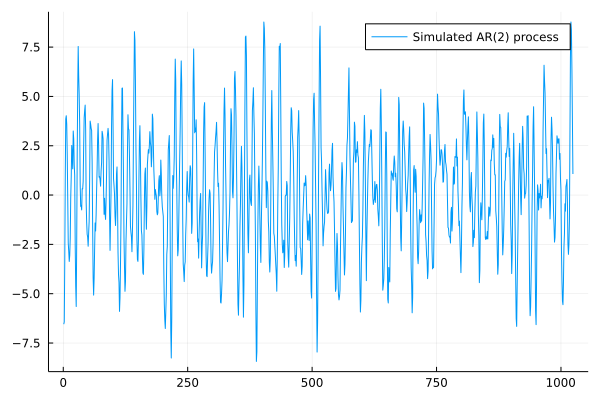

In [1]:
using Multitaper, Distributions, DSP, LinearAlgebra, Plots

Distributions.Random.seed!(123)
include(dirname(dirname(pathof(Multitaper)))*"/src/PlotsRecipes/Coherence_Plot.jl")

N = 1024
t = 1:N
d = Normal()

""" Simulate a sample of length N from an AR(p) process """
function ARsim(N::Int64,phi::Array{Float64,1})
  p = length(phi)-1
  ϕ = phi[1:p]
  σ = phi[end]
  ζ = σ*rand(Normal(),N)
  x = zeros(Float64, N + p)
  x[1:p] = σ*rand(Normal(),p) # Initial condition
  for i = (p+1):(N+p)
    x[i] = dot(x[(i-1):-1:(i - p)],ϕ) + ζ[i - p]
  end
  return x[(p+1):end]
end
ϕ = [1.5, -.75, 1.0]
x = ARsim(N + 50, ϕ)[51:end] 

# Gaps
Nmissing = 256 # 1/4 of the data
NN = N-Nmissing
N2 = Int64(N/2);

plot(x,label="Simulated AR(2) process")

We can evauate the spectral density of $x_t$. It is
$$ S_x(f) = \frac{1}{\left|1-\sum_{j=1}^p{\phi_j e^{-i2\pi j f}}\right|^2}.  $$

Using the simulated data and computing a conventional multitaper estimate of the spectrum, we get the next figure.

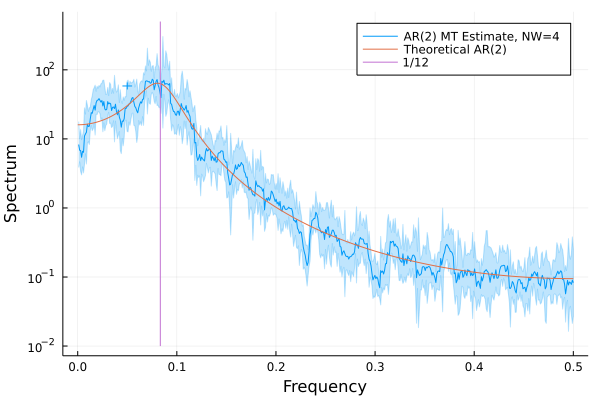

In [2]:
Sjk = multispec(x, jk = true, NW=5.0,K=9)
S = multispec(x, jk = false, NW=5.0,K=9)
ω = LinRange(0,0.5,Int64(N/2)+1)

# Parametric (AR(p)) spectrum
parspec(freq::Float64,ϕ::Union{Array{Float64,1},Float64},σ::Float64) =
      σ^2 / abs.(1.0 - dot(ϕ, exp.(-2*pi*im*freq*(1:length(ϕ))))).^2

fx = map(w -> parspec(w,ϕ[1:2],ϕ[3]), ω);

plot(Sjk,label="AR(2) MT Estimate, NW=4")

plot!(ω,fx,label="Theoretical AR(2)")
plot!((1/12)*ones(2,1),[1e-2,5e2],label="1/12",c = 4)

## Missing data estimate of the example with known spectrum

If we take the AR(2) data and give it different numbers of gaps, we get the following

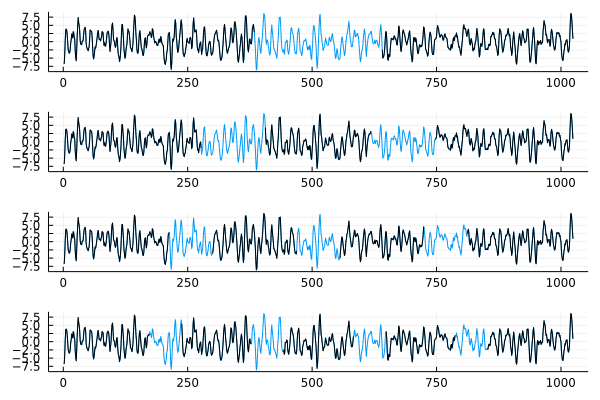

In [3]:
# generate four different patterns of gaps to compare estimates.
function Sampling(N::Int64, Nmissing::Int64, Ngaps::Int64)
    M = Int64(round(N/(Ngaps+1)))
    M2 = Int64(round(Nmissing/(2*Ngaps)))
    pt = map(i -> (i==0 ? 1 : (M*i+M2+1)):(i==Ngaps ? N : (M*(i+1)-M2)), 0:Ngaps)
    #qt = mapreduce(p->collect(p),vcat,pt)
    return pt
end

pt = map(Ngaps -> Sampling(N,Nmissing,Ngaps), 1:4)

p = [plot(t,x,legend=false), plot(t,x,legend=false), plot(t,x,legend=false), plot(t,x,legend=false)]

for i = 1:4
    map(tt -> plot!(p[i],tt,x[tt],label="",c=:black),pt[i])
end

plot(p...,layout=(4,1))

The missing-data spectrum computed on these four series is shown in the next plot.

Degrees of freedom get too small to assess F-test p-value.


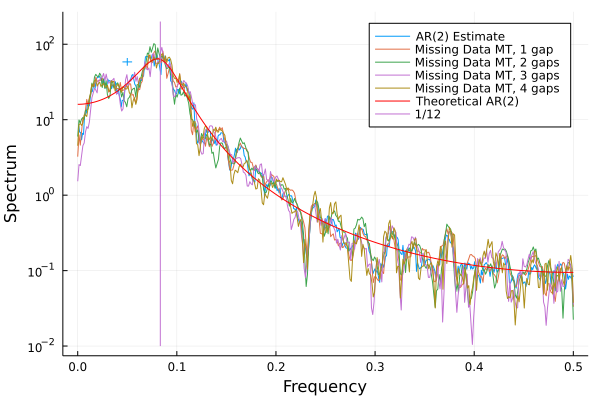

In [4]:
s2 = var(x)
vars = map(i -> var(x[vcat(collect.(pt[i])...)]), 1:4)
Sg = map(t->mdmultispec(Float64.(collect(t)),x[t],jk=false), vcat(collect.(pt[i])...) for i in 1:4)

pspec = plot(S,label="AR(2) Estimate",jk=false)


plot!(pspec, Sg[1].f,Sg[1].S*s2/vars[1],label="Missing Data MT, 1 gap")
plot!(pspec, Sg[2].f,Sg[2].S*s2/vars[2],label="Missing Data MT, 2 gaps",cross=false)
plot!(pspec, Sg[3].f,Sg[3].S*s2/vars[3],label="Missing Data MT, 3 gaps",cross=false)
plot!(pspec, Sg[4].f,Sg[4].S*s2/vars[4],label="Missing Data MT, 4 gaps",cross=false)

plot!(pspec, ω,fx,label="Theoretical AR(2)",c=:red)
plot!(pspec, (1/12)*ones(2,1),[1e-2,2e2],label="1/12",c = 4)


## Filter the dataset and add noise

Suppose there is a process $z_t$ which is generated from $x_t$ using an FIR linear filter 
$$z_t = \sum_{j=1}^q \psi_j x_{t-j}; \quad t = 0, \ldots, N-1$$
where $q=4$, $\psi_1 = 1.0$, $\psi_2 = -0.25$, $\psi_3 = 0.1$, $\psi_4 = -1.33$. It has spectrum 
$$ S_z(f) = \frac{\left|\sum_{j = 1}^q \psi_j e^{-2\pi i
j}\right|^2}{\left|1-\sum_{j=1}^p{\phi_j e^{-i2\pi j f}}\right|^2} $$
Let 
$$ y_t = z_t +\zeta_t, $$
where $\zeta_t$ is uncorrelated with the input, be the process of interest. Its spectrum is simply $S_z(f) = 1$. These are shown below. Note the logarithmic scale in the y-axis makes the process $z$, which is a convolution of $x_t$ with the filter, appear as the spectrum of $x$ *plus* the transfer function.

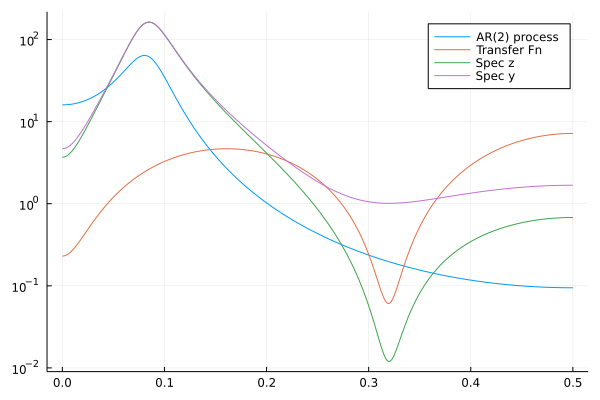

In [5]:
psi = [1.0,-0.25,0.1,-1.33]; p = 4

# FIR filter magnitude response
FIRmag(freq::Float64,ϕ::Union{Array{Float64,1},Float64},σ::Float64) =
      σ^2 * abs.(dot(ϕ[length(ϕ):-1:1], exp.(-2*pi*im*freq*(1:length(ϕ))))).^2

# FIR phase response
FIRphase(freq::Float64,ϕ::Union{Array{Float64,1},Float64}) =
      angle.(dot(ϕ[length(ϕ):-1:1], exp.(-2*pi*im*freq*(1:length(ϕ))))).^2

Lx = map(w -> FIRmag(w, psi, 1.0), ω);
Px = map(w -> FIRphase(w, psi), ω);

fz = Lx.*fx
fy = Lx.*fx .+ 1.0

plot(ω,fx,label="AR(2) process",yscale=:log10)
plot!(ω,Lx,label="Transfer Fn")
plot!(ω,fz,label="Spec z")
plot!(ω,fy,label="Spec y")

Plotting the original process and its filtered realizations, we get the following.

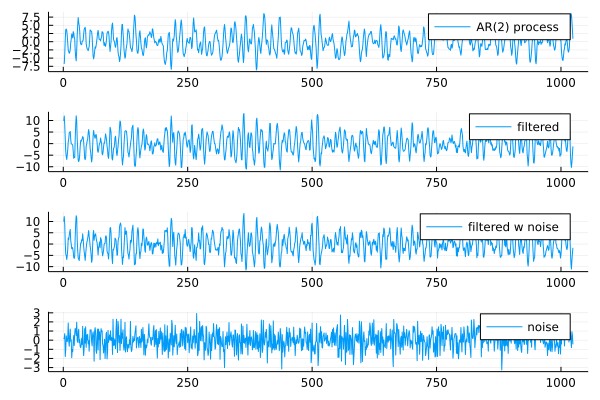

In [6]:
x2 = conv(x,psi)[p:end]
n = rand(d,N)
n ./= std(n)
y = x2.+n
plot(plot(x,label="AR(2) process"),plot(x2,label="filtered"),
    plot(y,label="filtered w noise"),plot(n,label="noise"),layout=(4,1))

This plot reproduces the figure from the paper.

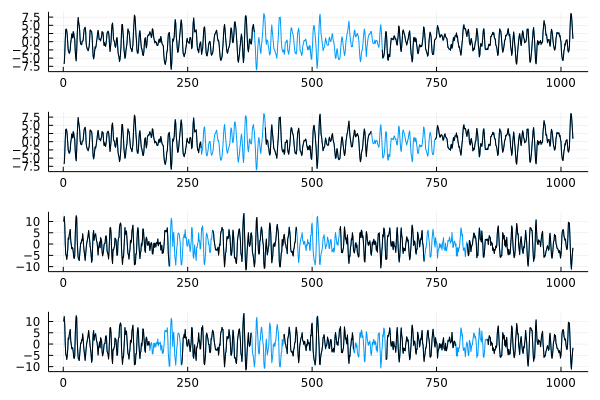

In [7]:

p = [plot(t,x,legend=false), plot(t,x,legend=false), plot(t,y,legend=false), plot(t,y,legend=false)]

for i = 1:2
    map(tt -> plot!(p[i],tt,x[tt],label="",c=:black),pt[i])
end

for i = 3:4
    map(tt -> plot!(p[i],tt,y[tt],label="",c=:black),pt[i])
end

p = plot(p...,layout=(4,1))

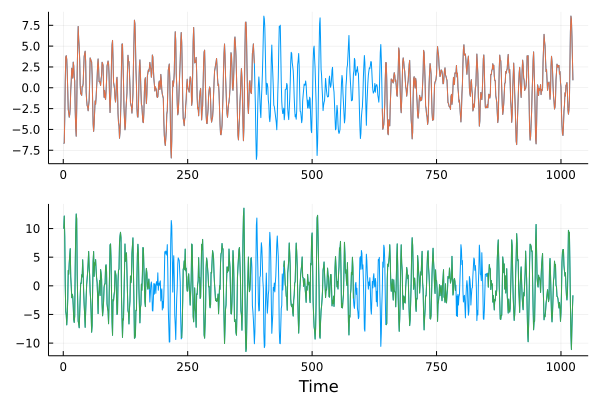

In [8]:
p = [plot(t,x,legend=false), plot(t,y,legend=false,xlabel = "Time")]

for i = 1
    map(tt -> plot!(p[i],tt,x[tt],label="",c=2),pt[i])
end

for i = 4
    map(tt -> plot!(p[2],tt,y[tt],label="",c=3),pt[i])
end

plot(p...,layout=(2,1))

Briefly ignoring the gaps and computing the spectra on the entire dataset, we find that the spectra contain periodic components at frequency (1/12), the MSC is large at that frequency, and the phase is near constant there.

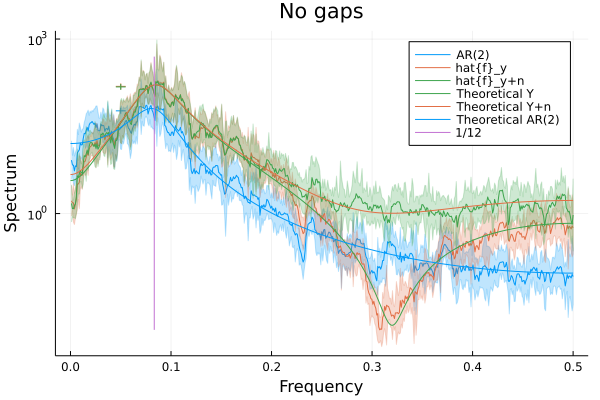

In [9]:
S2 = multispec(hcat(x,x2,y),jk=true,NW=5.0,K=9);

plot(S2[1][1],label="AR(2)",title="No gaps"); 
plot!(S2[1][2],label="hat{f}_y")
plot!(S2[1][3],label="hat{f}_y+n")

plot!(ω,Lx.*fx, label="Theoretical Y",c=3)
plot!(ω,fy, label="Theoretical Y+n",c=2)
plot!(ω,fx, label="Theoretical AR(2)",c=1)

plot!((1/12)*ones(2,1),[1e-2,5e2],label="1/12",c = 4)

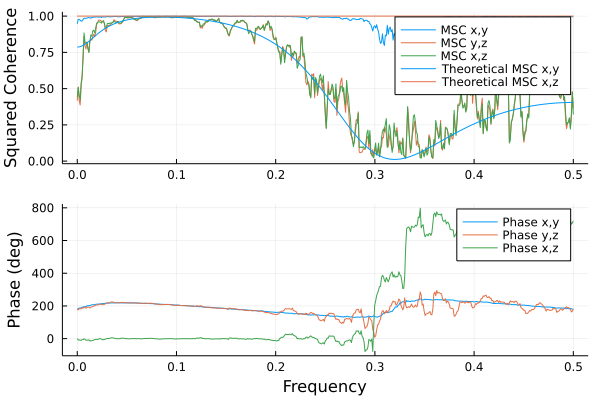

In [10]:
truemsc = Lx.*fx./(1.0.+Lx.*fx)
plot(S2[2], phase = true, label = ["MSC x,y" "MSC y,z" "MSC x,z" "Phase x,y" "Phase y,z" "Phase x,z"])
plot!(ω, truemsc, subplot = 1, label="Theoretical MSC x,y", c=1)
plot!([0,0.5],[1.0,1.0],subplot = 1,label="Theoretical MSC x,z", c=2)

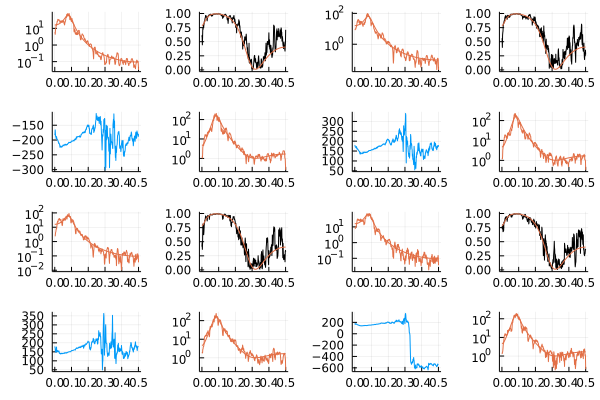

In [11]:

SG2 = map(tt->mdmultispec(Float64.(collect(tt)),hcat(x[tt],y[tt])), vcat(collect.(pt[i])...) for i in 1:4)

function plotsg(sg)
    p = plot(sg, legend = false)
    plot!(p,ω,fx,subplot=1,label="Theoretical AR(2)",legend=false)
    plot!(p,ω,fy, subplot = 4, label="Theoretical AR(2)",legend=false)
    plot!(p,ω,Lx.*fx./(1.0.+Lx.*fx),subplot=2,label="Theoretical MSC",legend=false)
    return p
end

plts = map(sg->plotsg(sg),SG2)

plot(plts...)

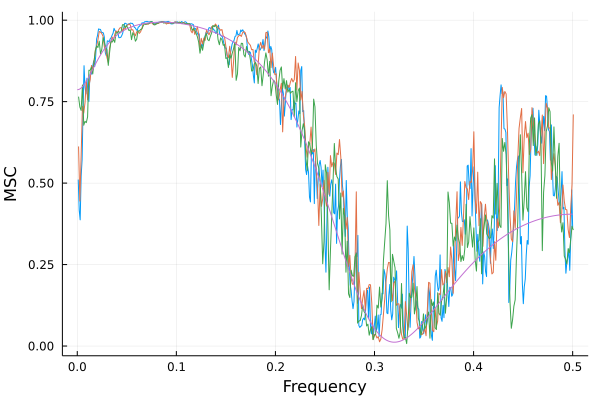

In [12]:
pcoh = plot(S2[2][1,3],sigaxis=false,siglines=false,mscaxis = false,msclines=false,label="No gaps",jk=false,grid=false)

plot!(pcoh,SG2[1][2][1,2],sigaxis=false,siglines=false,mscaxis = false,msclines=false,jk=false,label="One gap",c=2)#,force_ylims=[0,10])
#plot!(pcoh,SG2[2][2][1,2],sigaxis=false,siglines=false,mscaxis = false,msclines=false,jk=false,label="Two gaps")#,force_ylims=[0,10])
#plot!(pcoh,SG2[3][2][1,2],sigaxis=false,siglines=false,mscaxis = false,msclines=false,jk=false,label="Three gaps")#,force_ylims=[0,10])
plot!(pcoh,SG2[4][2][1,2],sigaxis=false,siglines=false,mscaxis = false,msclines=false,jk=false,label="Four gaps",c=3)#,force_ylims=[0,10])

plot!(pcoh,ω,Lx.*fx./(1.0.+Lx.*fx),label="Theoretical MSC",legend=false,c=4)

## Different gaps

When the data have different gaps, can one still compute the coherence? Yes. 

In [13]:
function wt_ave(S1::EigenCoefficient, S2::EigenCoefficient)
    sum((S1.coef.*sqrt.(S1.wts)).*conj.(S2.coef.*sqrt.(S2.wts)), dims = 2)
end

function unwrapphase(y, typ=:rad)
  lims         = (typ==:rad) ? pi : 180
  x            = copy(y)
  dy           = diff(y, dims = 1)
  for i = (length(y)-1):-1:1
    if abs(dy[i]) >= lims
      x[(i+1):end] .+= -sign(dy[i])*(2*lims)
    end
  end
  return x[:]
end

# Outputs cross spectrum or coherence for the missing data multitaper spectrum
function mdmultispec_cross(S1::MTSpectrum, S2::MTSpectrum; 
                   outp=:coh, jk=false)
    EC1 = EigenCoefficient(vcat(S1.coef.coef[end:-1:2, :], S1.coef.coef), vcat(S1.coef.wts[end:-1:2, :], S1.coef.wts))
    EC2 = EigenCoefficient(vcat(S2.coef.coef[end:-1:2, :], S2.coef.coef), vcat(S2.coef.wts[end:-1:2, :], S2.coef.wts))
  
    if jk
        # You can only do this if the temporal indices are the same for both series
        S, jv    = jknife(EC1, EC2, outp) 
        phase, jphase = jknife_phase(EC1, EC2) 
    else 
        temp = wt_ave(EC1, EC2)
        S = abs.(temp)
        phase = unwrapphase(angle.(temp)*180/(2*pi))
        jv = nothing
    end
    S   .*= (outp == :spec) ? S1.params.dt./sqrt.(sum(EC1.wts, dims=2).*sum(EC2.wts, dims=2)) : 1.0
    if outp == :coh
        S ./= (real.(wt_ave(EC1, EC1)).*real.(wt_ave(EC2, EC2)))
    end
  params = [S1.params, S2.params]   
  halffreq = length(S1.f)
  if outp == :spec
    return ((1/S1.params.dt)*range(-0.5, 0.5, length=S1.params.M+2)[1:S1.params.M+1], 
                S, phase, params, [EC1, EC2], 
                (jk ?  [jv, jphase] : jv)) 
  elseif outp == :coh
        return MTCoherence(S1.f, S[:], phase, params[1], nothing, 
                       (jk ?  [jv,jphase] : jv), nothing) 
  end

end



mdmultispec_cross (generic function with 1 method)

In [14]:
# first index of SG is number of gaps, second is selecting the spectrum and third is 
# selecting the first eigencoefficient
Crosspec14 = mdmultispec_cross(SG2[1][1][1], SG2[4][1][1], outp = :spec);

Et voila, the result of using different amounts of gaps. Note that the autospectrum estimate is more variable than the original multitaper with no gaps (95% CI shown) 

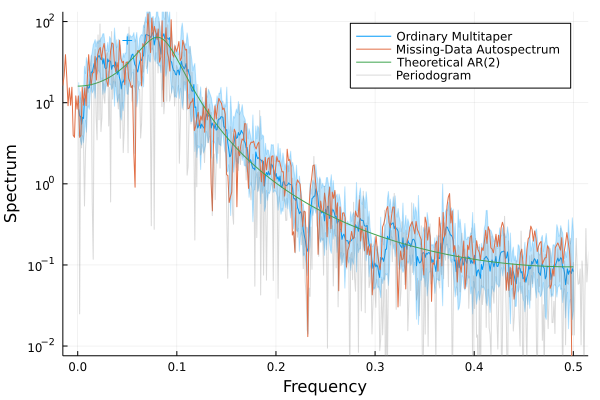

In [15]:
a = plot(S2[1][1], label="Ordinary Multitaper")
plot!(a, Crosspec14[1],3*2*Crosspec14[2], ylabel = "Spectrum", label = "Missing-Data Autospectrum", xlims=[0,0.5], ylims = [1e-2, 1e2])
plot!(a,ω,fx,subplot=1,label="Theoretical AR(2)")
#b = plot(Crosspec14[1],Crosspec14[3], ylabel="Phase", xlims=[0,0.5], 
#    xlabel="Normalized Frequency",legend=false)
using FFTW
#plot(a,b,layout = (2,1))
plot!(LinRange(0,1,length(x)+1)[2:length(x)], abs2.(fft(x))[2:end]/(40*sqrt(N)), c = :gray, label = "Periodogram",linealpha=0.3) #RGBA(1,1,1,0.9))
# png(dir*"Autospectrum")